In [ ]:
%matplotlib inline

In [ ]:
!pip install gymnasium[classic_control]
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pygame-2.1.3.dev8-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.7 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pygame-2.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.3.dev8
    Uninstalling pygame-2.1.3.dev8:
      Successfully uninstalled pygame-2.1.3.dev8



# 강화 학습 (DQN) 튜토리얼
**Author**: [Adam Paszke](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
  **번역**: [황성수님의 번역본 수정(서현준)](https://github.com/adonisues)

이 튜토리얼에서는 [OpenAI Gym](https://www.gymlibrary.dev/)_ 의
CartPole-v1 태스크에서 DQN (Deep Q Learning) 에이전트를 학습하는데
PyTorch를 사용하는 방법을 보여드립니다.

**태스크**

에이전트는 연결된 막대가 똑바로 서 있도록 카트를 왼쪽이나 오른쪽으로
움직이는 두 가지 동작 중 하나를 선택해야 합니다.
다양한 알고리즘과 시각화 기능을 갖춘 공식 순위표를
[Gym 웹사이트](https://www.gymlibrary.dev/environments/classic_control/cart_pole)_ 에서 찾을 수 있습니다.

![](https://pytorch.org/tutorials/_images/cartpole.gif)

에이전트가 현재 환경 상태를 관찰하고 행동을 선택하면,
환경이 새로운 상태로 *전환* 되고 작업의 결과를 나타내는 보상도 반환됩니다.
이 태스크에서 매 타임스텝 증가마다 보상이 +1이 되고, 만약 막대가 너무 멀리
떨어지거나 카트가 중심에서 2.4 유닛 이상 멀어지면 환경이 중단됩니다.
이것은 더 좋은 시나리오가 더 오랫동안 더 많은 보상을 축적하는 것을 의미합니다.

카트폴 태스크는 에이전트에 대한 입력이 환경 상태(위치, 속도 등)를 나타내는
4개의 실제 값이 되도록 설계되었습니다. 그러나 신경망은 순수하게 그 장면을 보고
태스크를 해결할 수 있습니다 따라서 카트 중심의 화면 패치를 입력으로 사용합니다.
이 때문에 우리의 결과는 공식 순위표의 결과와 직접적으로 비교할 수 없습니다.
우리의 태스크는 훨씬 더 어렵습니다.
불행히도 모든 프레임을 렌더링해야되므로 이것은 학습 속도를 늦추게됩니다.

엄밀히 말하면, 현재 스크린 패치와 이전 스크린 패치 사이의 차이로 상태를 표시할 것입니다.
이렇게하면 에이전트가 막대의 속도를 한 이미지에서 고려할 수 있습니다.

**패키지**

먼저 필요한 패키지를 가져옵니다. 첫째, 환경을 위해
[gym](https://github.com/openai/gym)_ 이 필요합니다.

```bash
%%bash
pip install gym[classic_control]
```
또한 PyTorch에서 다음을 사용합니다:

-  신경망 (``torch.nn``)
-  최적화 (``torch.optim``)
-  자동 미분 (``torch.autograd``)
-  시각 태스크를 위한 유틸리티들 (``torchvision`` - [a separate
   package](https://github.com/pytorch/vision)_).


In [ ]:
import gymnasium
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gymnasium.make('CartPole-v1') #v0 -> 업그레이드

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device {device}")

device cpu


## 재현 메모리(Replay Memory)

우리는 DQN 학습을 위해 경험 재현 메모리를 사용할 것입니다.
에이전트가 관찰한 전환(transition)을 저장하고 나중에 이 데이터를
재사용할 수 있습니다. 무작위로 샘플링하면 배치를 구성하는 전환들이
비상관(decorrelated)하게 됩니다. 이것이 DQN 학습 절차를 크게 안정시키고
향상시키는 것으로 나타났습니다.

이를 위해서 두개의 클래스가 필요합니다:

-  ``Transition`` - 우리 환경에서 단일 전환을 나타내도록 명명된 튜플.
   그것은 화면의 차이인 state로 (state, action) 쌍을 (next_state, reward) 결과로 매핑합니다.
-  ``ReplayMemory`` - 최근 관찰된 전이를 보관 유지하는 제한된 크기의 순환 버퍼.
   또한 학습을 위한 전환의 무작위 배치를 선택하기위한
   ``.sample ()`` 메소드를 구현합니다.



In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """transition 저장"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

이제 모델을 정의합시다. 그러나 먼저 DQN이 무엇인지 간단히 요약해 보겠습니다.

## DQN 알고리즘

우리의 환경은 결정론적이므로 여기에 제시된 모든 방정식은 단순화를 위해
결정론적으로 공식화됩니다. 강화 학습 자료은 환경에서 확률론적 전환에
대한 기대값(expectation)도 포함할 것입니다.

우리의 목표는 할인된 누적 보상 (discounted cumulative reward)을
극대화하려는 정책(policy)을 학습하는 것입니다.
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, 여기서
$R_{t_0}$ 는 *반환(return)* 입니다. discount 상수,
$\gamma$, 는 $0$ 과 $1$ 의 상수이고 합계가
수렴되도록 보장합니다. 에이전트에게 불확실한 먼 미래의 보상이
가까운 미래의 것에 비해 덜 중요하게 만들고, 이것은 상당히 합리적입니다.

Q-learning의 주요 아이디어는 만일 함수 $Q^*: State \times Action \rightarrow \mathbb{R}$ 를
가지고 있다면 반환이 어떻게 될지 알려줄 수 있고,
만약 주어진 상태(state)에서 행동(action)을 한다면, 보상을 최대화하는
정책을 쉽게 구축할 수 있습니다:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

그러나 세계(world)에 관한 모든 것을 알지 못하기 때문에,
$Q^*$ 에 도달할 수 없습니다. 그러나 신경망은
범용 함수 근사자(universal function approximator)이기 때문에
간단하게 생성하고 $Q^*$ 를 닮도록 학습할 수 있습니다.

학습 업데이트 규칙으로, 일부 정책을 위한 모든 $Q$ 함수가
Bellman 방정식을 준수한다는 사실을 사용할 것입니다:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

평등(equality)의 두 측면 사이의 차이는
시간차 오류(temporal difference error), $\delta$ 입니다.:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

오류를 최소화하기 위해서 [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_ 를 사용합니다.
Huber loss 는 오류가 작으면 평균 제곱 오차( mean squared error)와 같이
동작하고 오류가 클 때는 평균 절대 오류와 유사합니다.
- 이것은 $Q$ 의 추정이 매우 혼란스러울 때 이상 값에 더 강건하게 합니다.
재현 메모리에서 샘플링한 전환 배치 $B$ 에서 이것을 계산합니다:

\begin{align}{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} {L}(\delta)\end{align}

\begin{align}\text{where} \quad {L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-네트워크

우리 모델은 현재와 이전 스크린 패치의 차이를 취하는
CNN(convolutional neural network) 입니다. 두가지 출력 $Q(s, \mathrm{left})$ 와
$Q(s, \mathrm{right})$ 가 있습니다. (여기서 $s$ 는 네트워크의 입력입니다)
결과적으로 네트워크는 주어진 현재 입력에서 각 행동의 *기대값* 을 예측하려고 합니다.




In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions) # n_actions = 2 / left or right

    #  output : next action = tensor([[left0exp,right0exp]...])
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

-  ``select_action`` - Epsilon Greedy 정책에 따라 행동을 선택합니다. 간단히 말해서, 가끔 모델을 사용하여 행동을 선택하고 때로는 단지 하나를 균일하게 샘플링할 것입니다. 임의의 액션을 선택할 확률은 ``EPS_START`` 에서 시작해서 ``EPS_END`` 를 향해 지수적으로 감소할 것입니다 ``EPS_DECAY`` 는 감쇠 속도를 제어합니다.
-  ``plot_durations`` - 지난 100개 에피소드의 평균(공식 평가에서 사용 된 수치)에 따른 에피소드의 지속을 도표로 그리기 위한 헬퍼. 도표는 기본 훈련 루프가 포함 된 셀 밑에 있으며, 매 에피소드마다 업데이트됩니다.

In [ ]:

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

episode_durations = []
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

### Training loop

최종적으로 모델 학습을 위한 코드.

여기서, 최적화의 한 단계를 수행하는 ``optimize_model`` 함수를 찾을 수 있습니다.
먼저 배치 하나를 샘플링하고 모든 Tensor를 하나로 연결하고
$Q(s_t, a_t)$ 와  $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$ 를 계산하고
그것들을 손실로 합칩니다. 우리가 설정한 정의에 따르면 만약 $s$ 가
마지막 상태라면 $V(s) = 0$ 입니다.
또한 안정성 추가 위한 $V(s_{t+1})$ 계산을 위해 목표 네트워크를 사용합니다.모든 step에서 ``TAU``를 통해 target network가 업데이트됩니다. [soft update](https://arxiv.org/abs/1509.02971)




In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

아래에서 주요 학습 루프를 찾을 수 있습니다. 처음으로 환경을
재설정하고 ``상태`` Tensor를 초기화합니다. 그런 다음 행동을
샘플링하고, 그것을 실행하고, 다음 화면과 보상(항상 1)을 관찰하고,
모델을 한 번 최적화합니다. 에피소드가 끝나면 (모델이 실패)
루프를 다시 시작합니다.

아래에서는 GPU를 사용할 수 있는 경우 `num_episodes`를 600으로 설정하고, 그렇지 않은 경우 50개의 에피소드를 예약하여 훈련에 너무 오래 걸리지 않도록 합니다. 그러나 50개의 에피소드만으로는 Cartpole에서 좋은 성능을 관찰하기에는 충분하지 않습니다. 600개의 훈련 에피소드 내에서 모델이 지속적으로 500개의 스텝을 달성하는 것을 볼 수 있어야 합니다. RL 에이전트 훈련은 노이즈가 많은 과정일 수 있으므로 수렴이 관찰되지 않는 경우 훈련을 다시 시작하면 더 나은 결과를 얻을 수 있습니다.



Complete


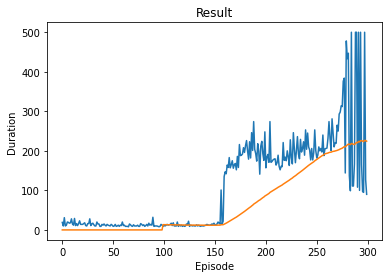

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        # action 선택 
        action = select_action(state)
        #observation [카트의 위치, 카트의 속도, 막대기의 각도, 막대기의 회전율]
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

#### max_episode_steps = 500


다음은 전체 결과 데이터 흐름을 보여주는 다이어그램입니다.

<img src="https://pytorch.org/tutorials/_images/reinforcement_learning_diagram.jpg" width="600px" height="300px" title="reinforcement_learning_diagram">

행동은 무작위 또는 정책에 따라 선택되어, gym 환경에서 다음 단계 샘플을 가져옵니다.
결과를 재현 메모리에 저장하고 모든 반복에서 최적화 단계를 실행합니다.
최적화는 재현 메모리에서 무작위 배치를 선택하여 새 정책을 학습합니다.
"이전" target_net은 최적화에서 기대 Q 값을 계산하는 데에도 사용되고,
최신 상태를 유지하기 위해 가끔 업데이트됩니다.




### Test Deep Model

In [ ]:
class TDQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(TDQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, 128)
        self.layer6 = nn.Linear(128, n_actions) # n_actions = 2 / left or right

    #  output : next action = tensor([[left0exp,right0exp]...])
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
        return self.layer6(x)

Complete


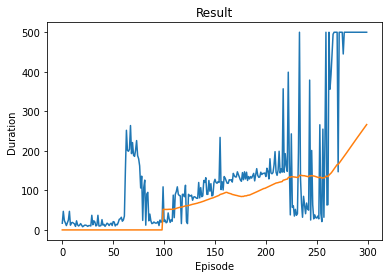

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

episode_durations = []
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = TDQN(n_observations, n_actions).to(device)
target_net = TDQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        # action 선택 
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True) 
plt.ioff()
plt.show()


In [ ]:
print(f"action \t\t {action}")
print(f"state \t\t {state}")
print(f"observation \t {observation}")
print(f"reward \t\t {reward}")
print(f"terminated \t {terminated}") # State Fail?
print(f"truncated \t {truncated}") # time value 
print(f"done \t\t {done}")
print(f"next_state \t {next_state}")

action 		 tensor([[0]])
state 		 tensor([[ 1.0055,  0.3511, -0.0704, -0.5236]])
observation 	 [ 1.0055181   0.35105905 -0.07036138 -0.5235879 ]
reward 		 tensor([1.])
terminated 	 False
truncated 	 True
done 		 True
next_state 	 tensor([[ 1.0055,  0.3511, -0.0704, -0.5236]])


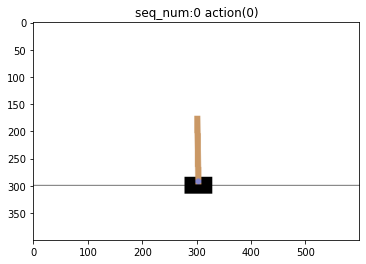

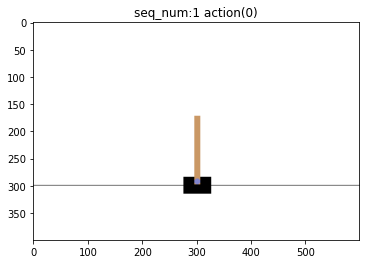

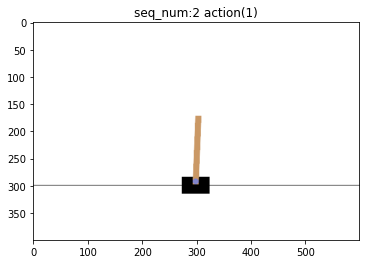

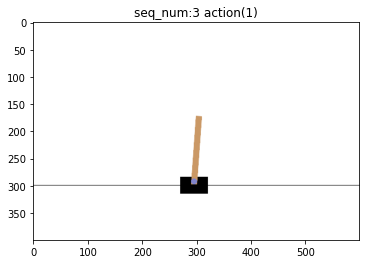

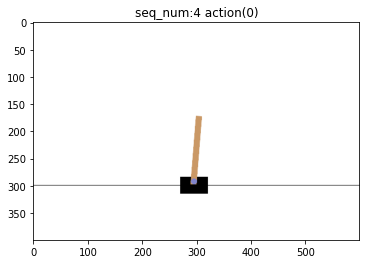

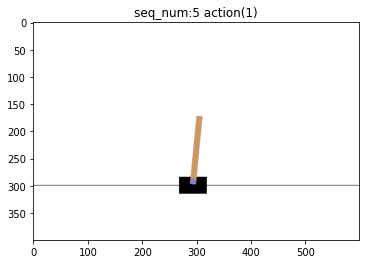

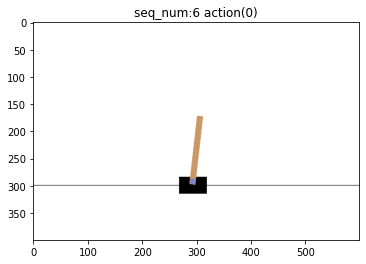

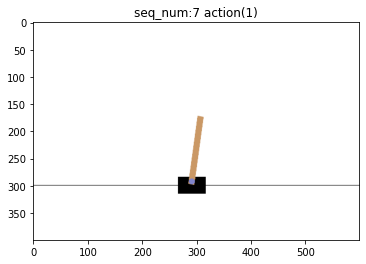

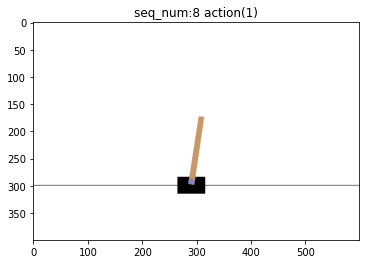

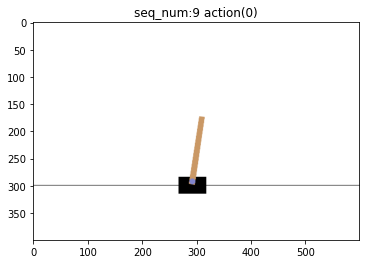

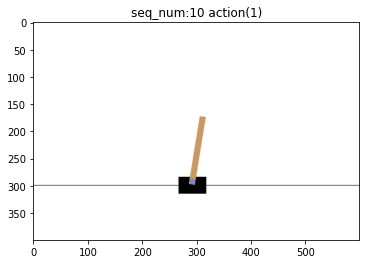

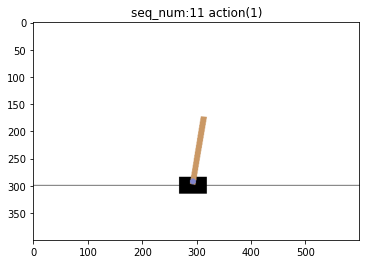

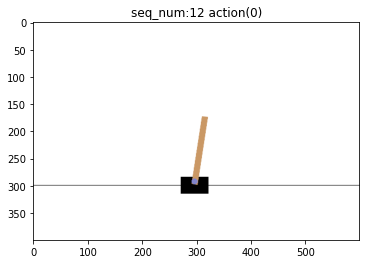

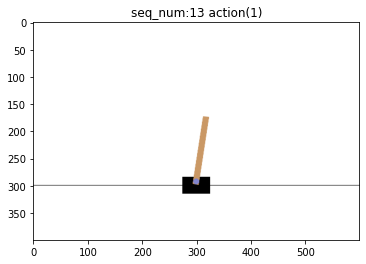

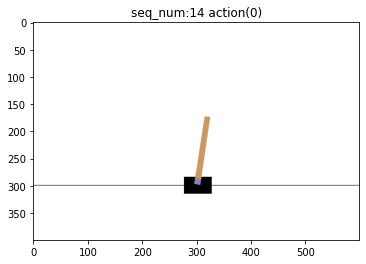

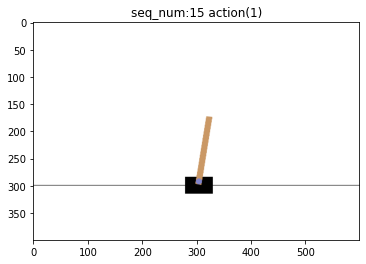

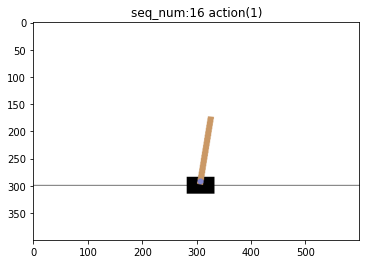

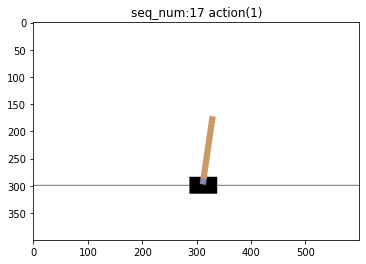

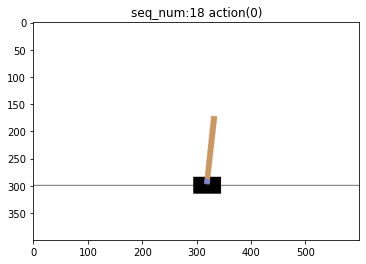

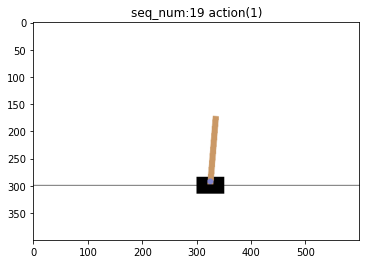

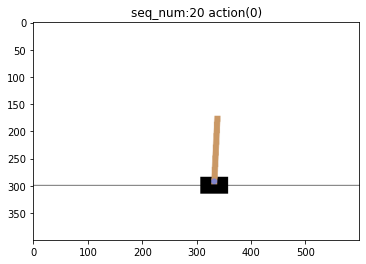

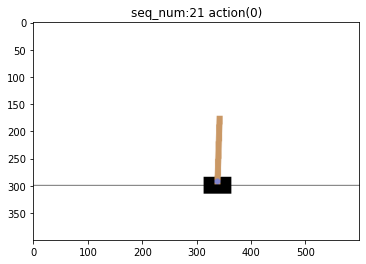

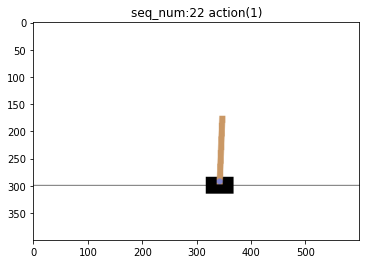

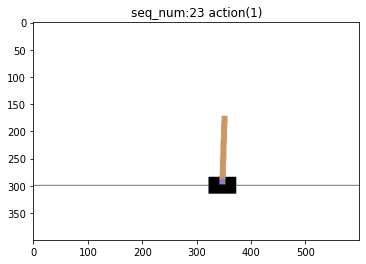

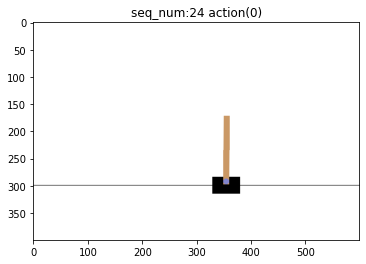

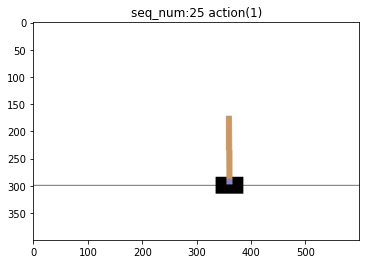

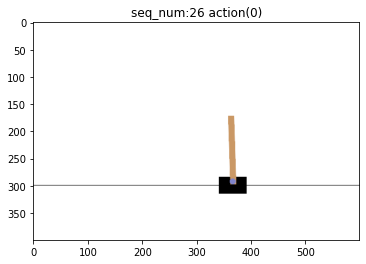

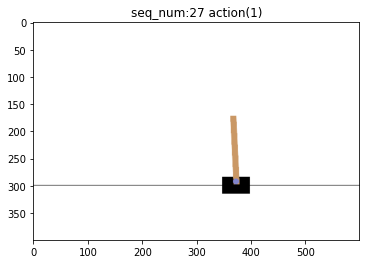

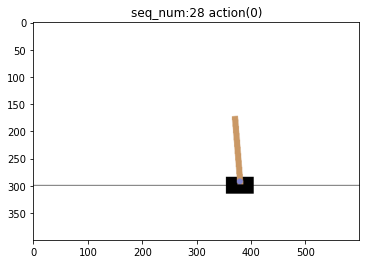

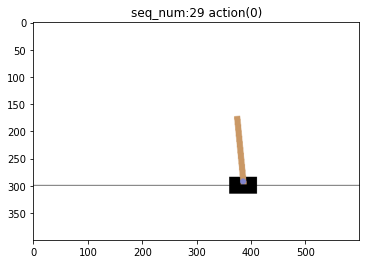

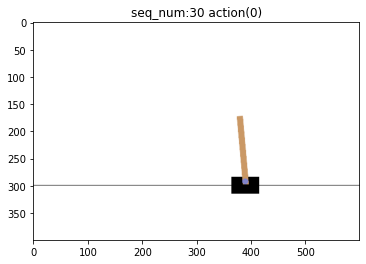

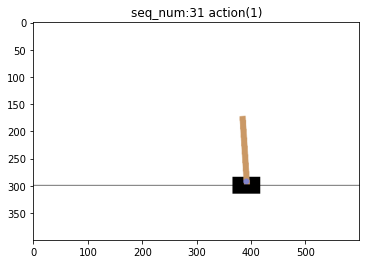

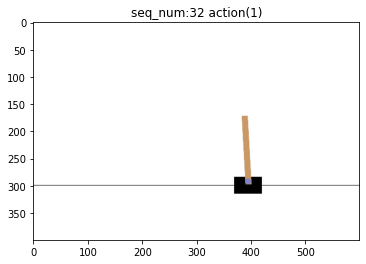

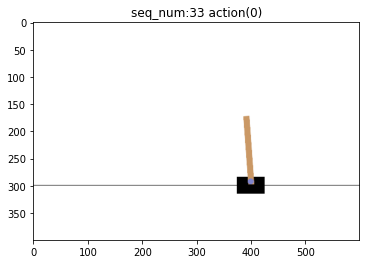

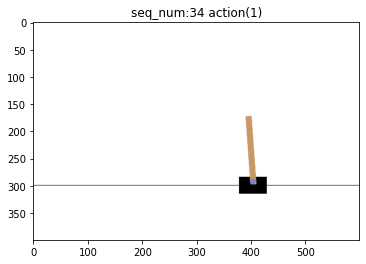

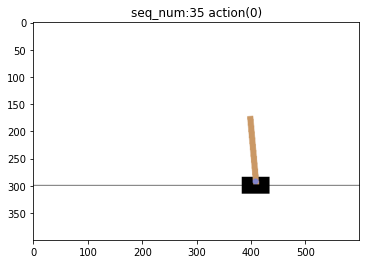

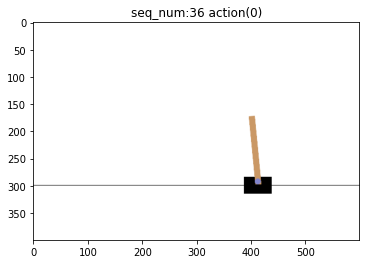

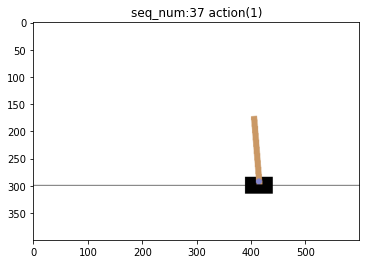

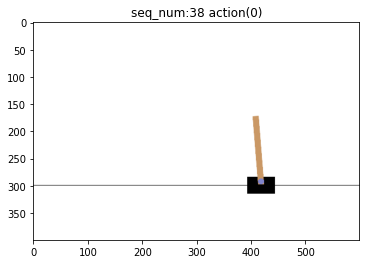

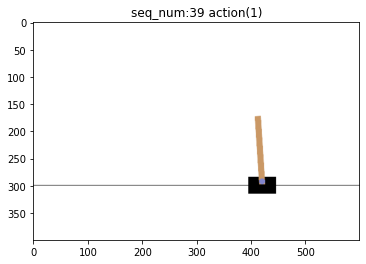

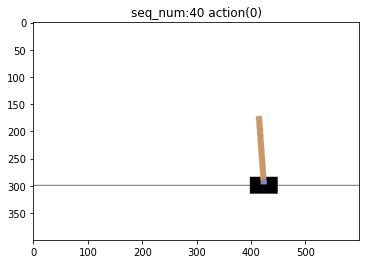

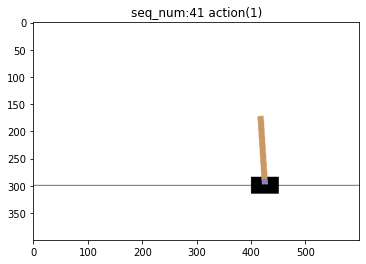

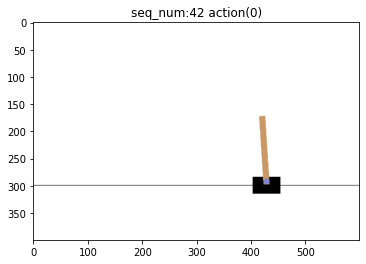

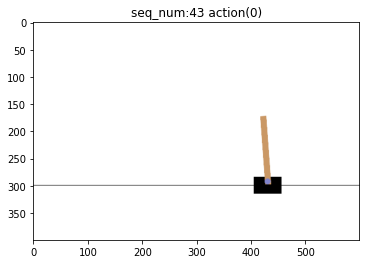

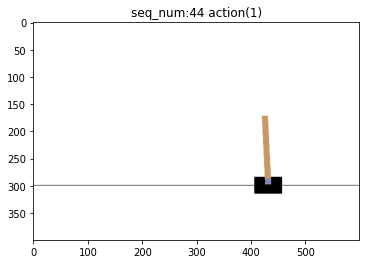

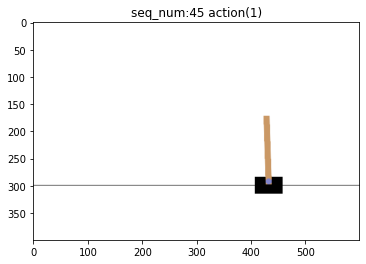

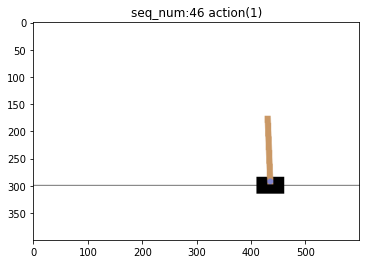

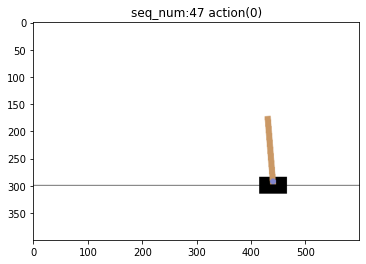

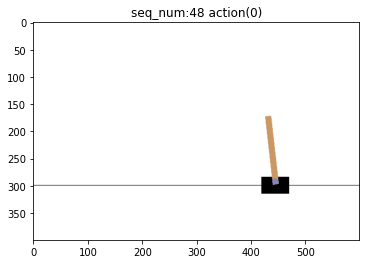

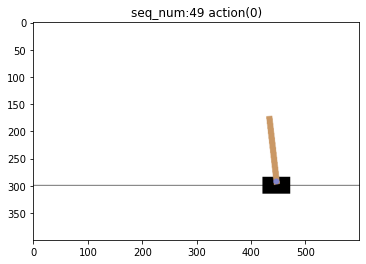

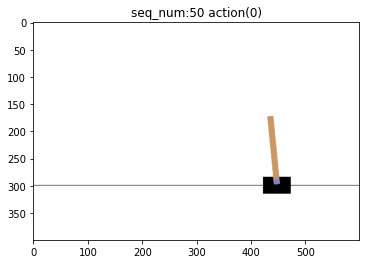

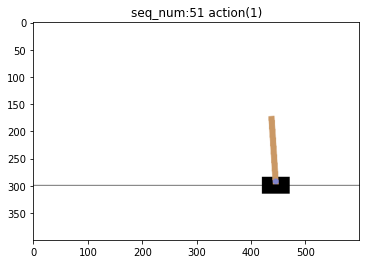

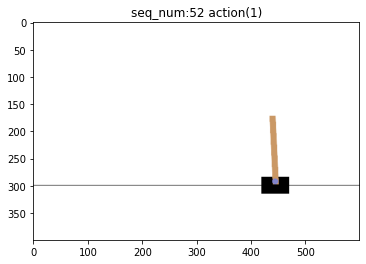

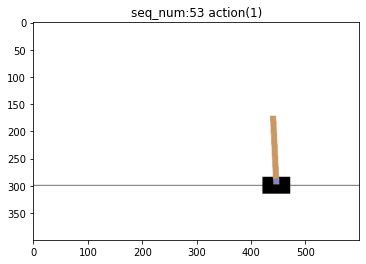

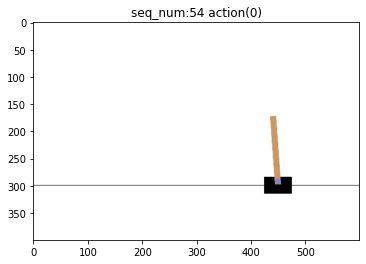

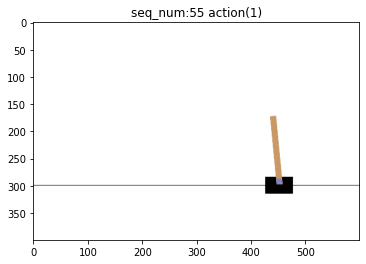

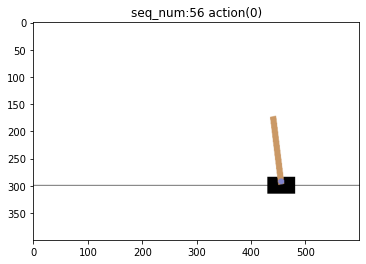

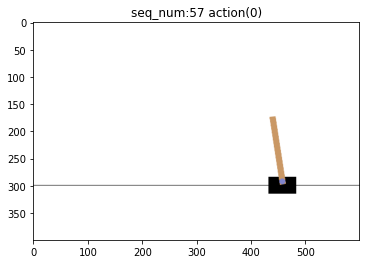

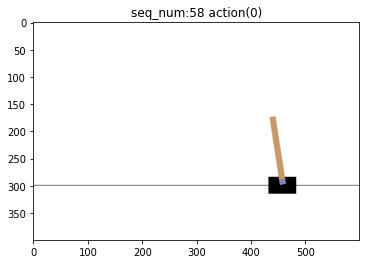

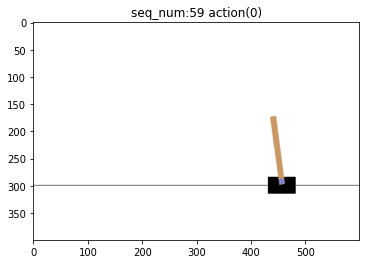

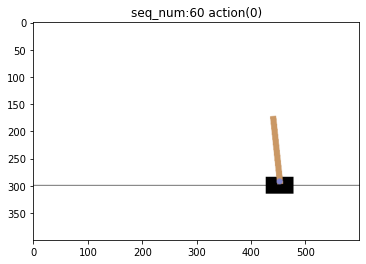

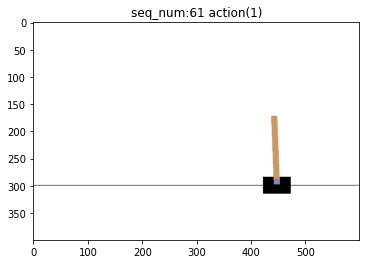

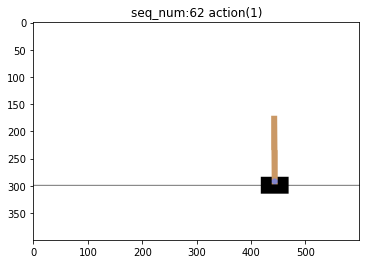

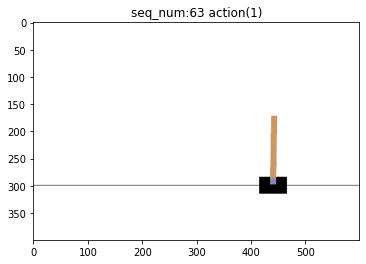

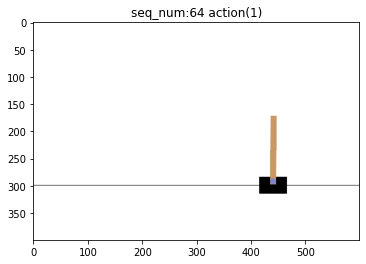

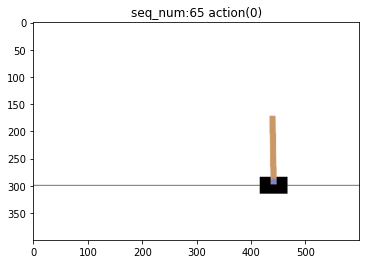

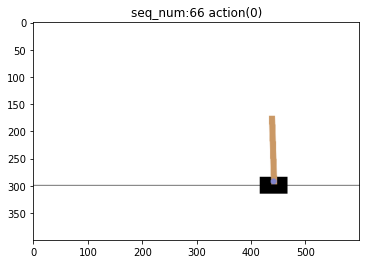

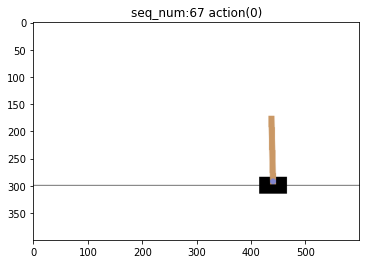

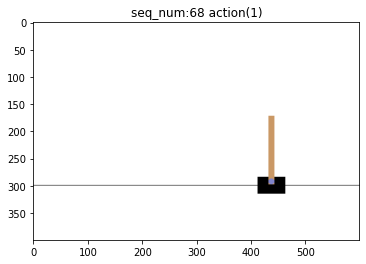

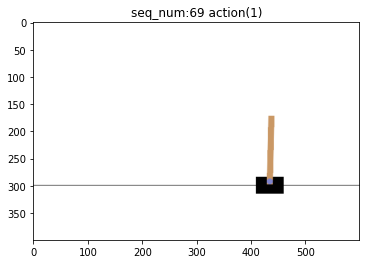

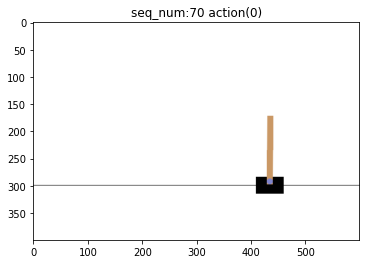

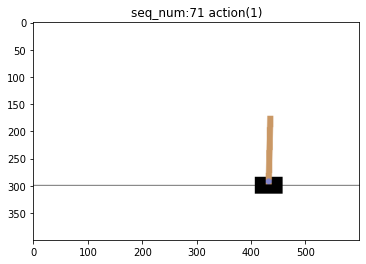

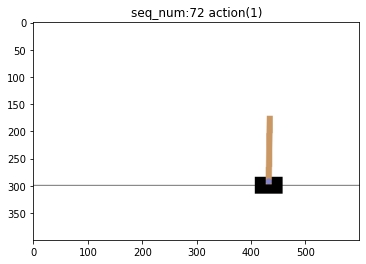

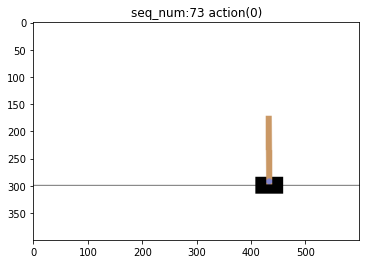

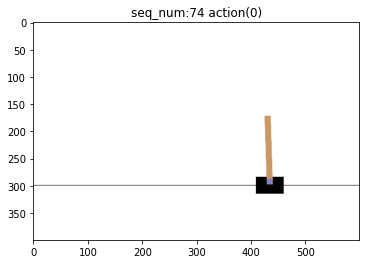

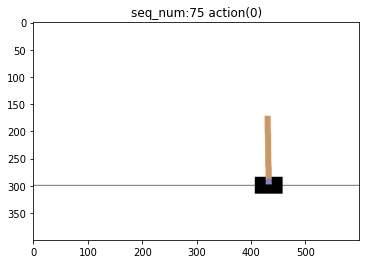

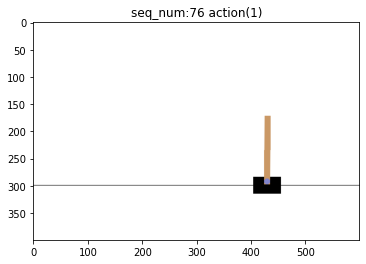

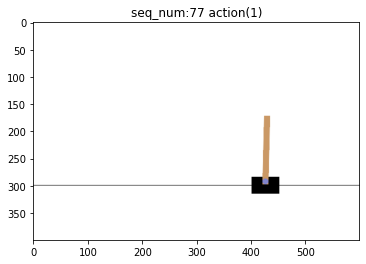

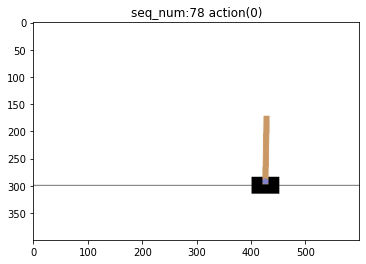

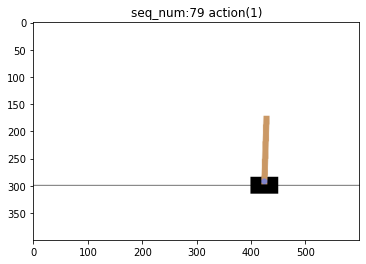

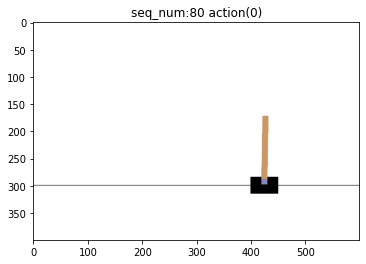

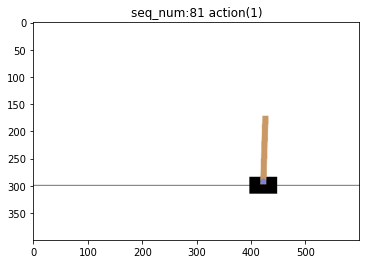

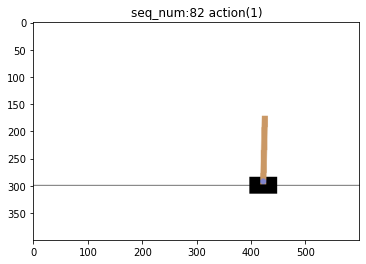

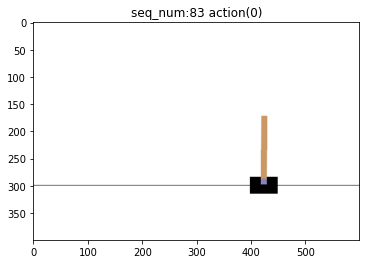

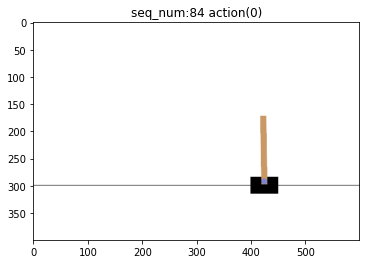

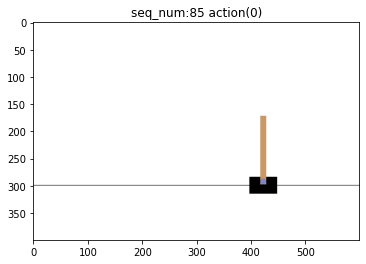

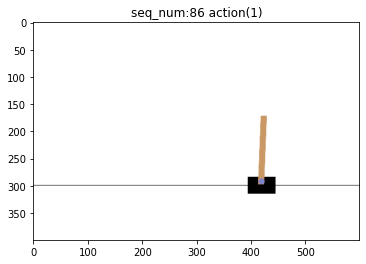

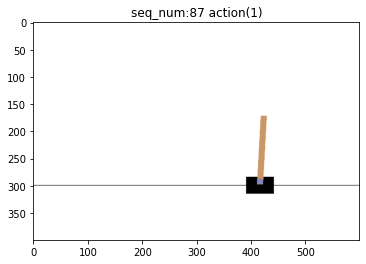

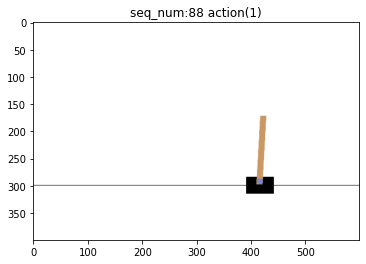

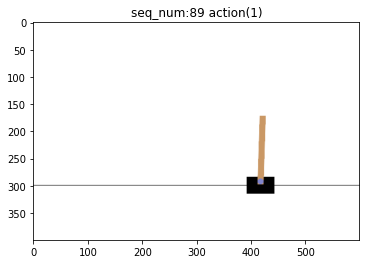

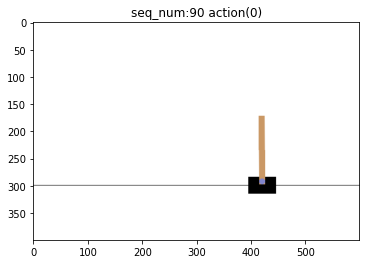

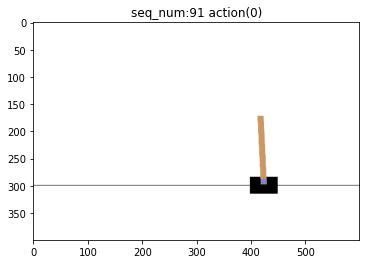

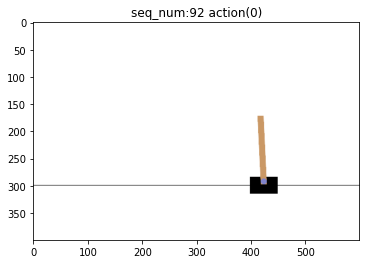

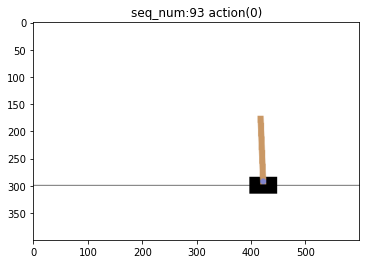

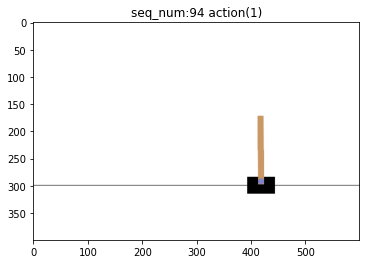

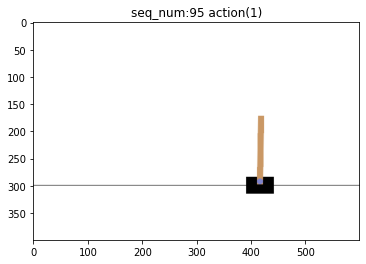

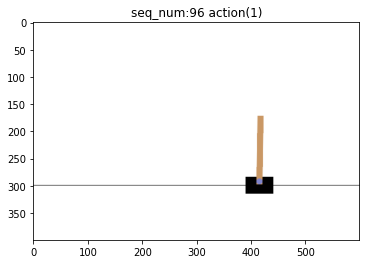

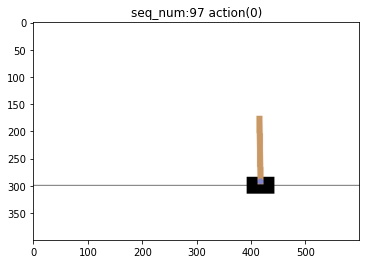

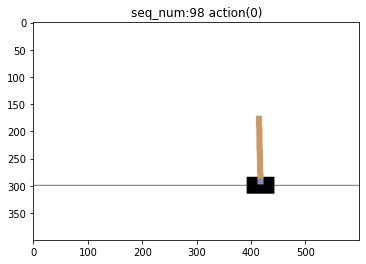

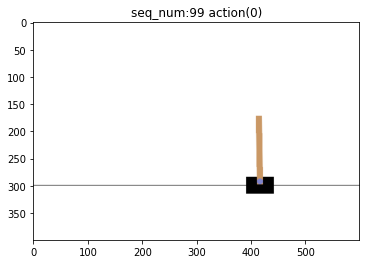

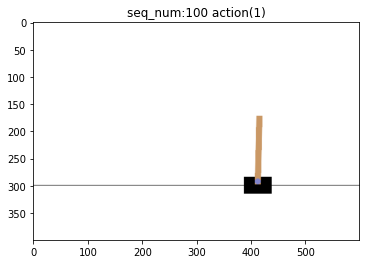

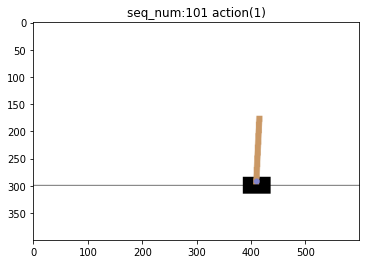

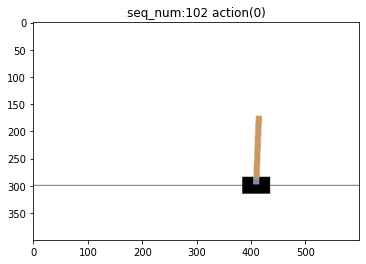

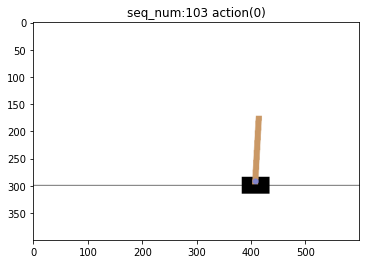

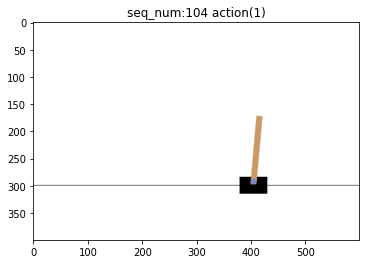

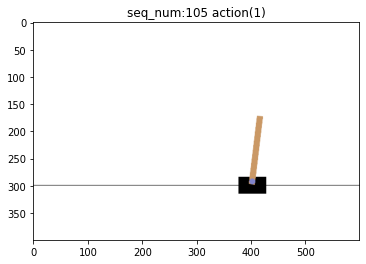

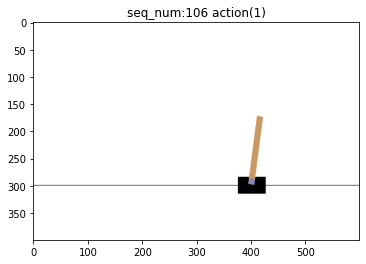

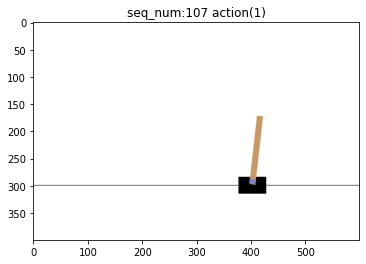

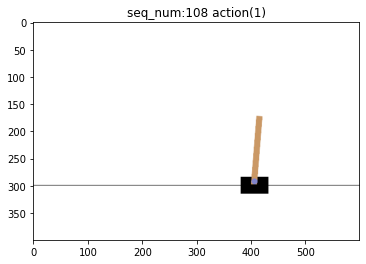

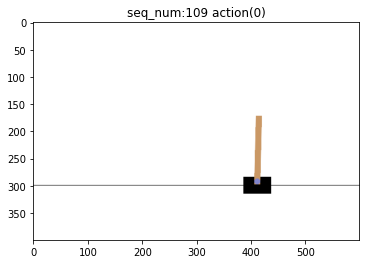

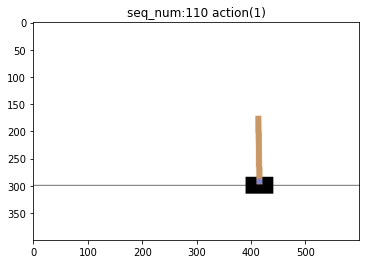

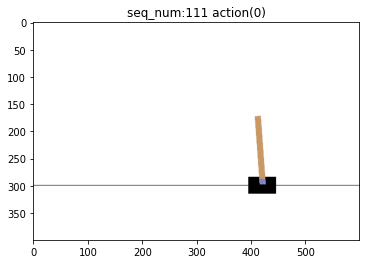

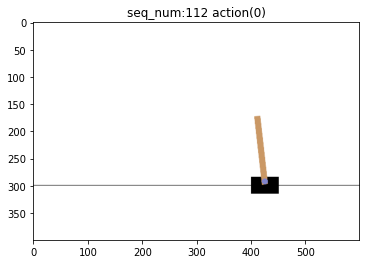

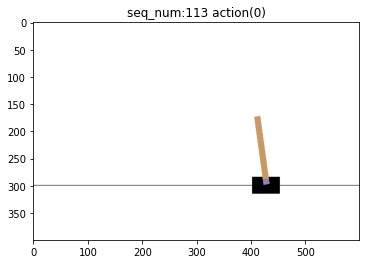

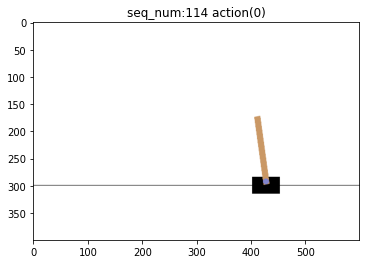

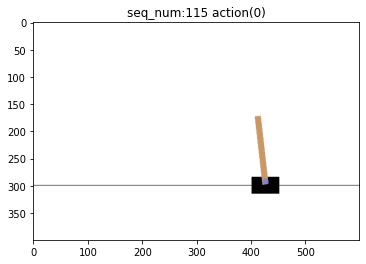

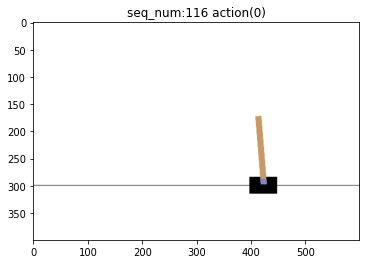

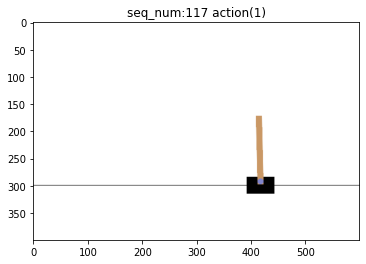

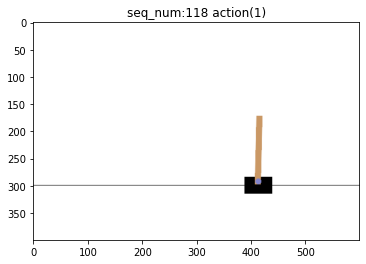

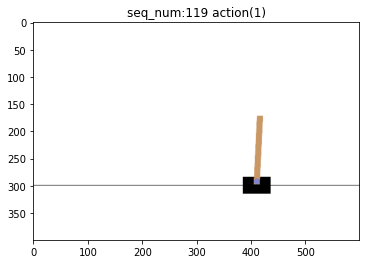

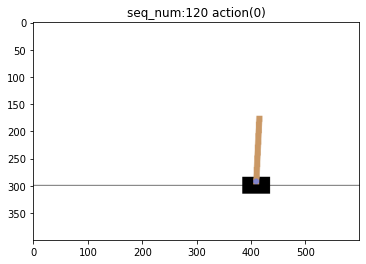

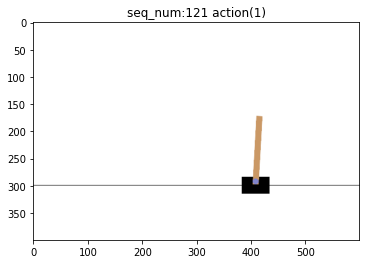

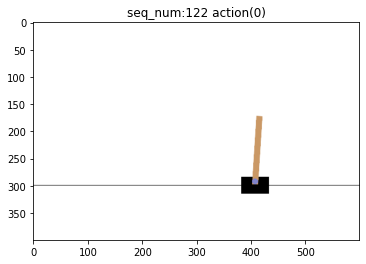

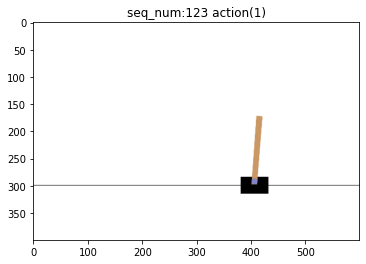

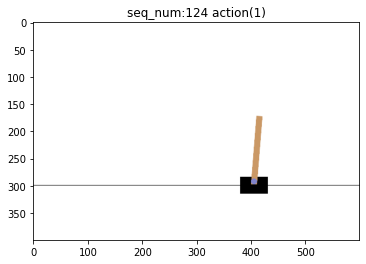

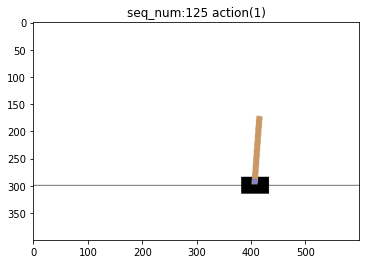

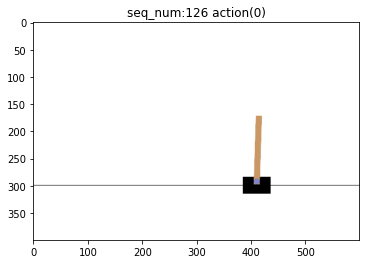

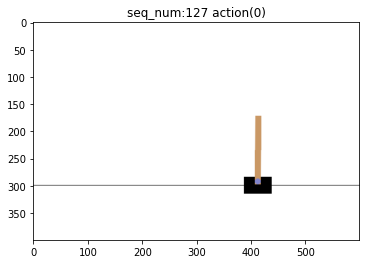

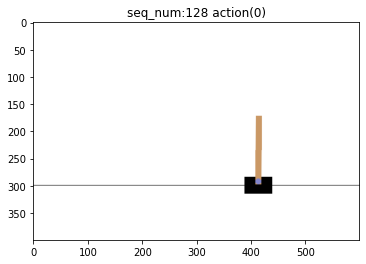

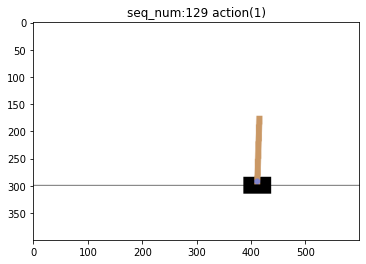

KeyboardInterrupt: ignored

In [ ]:
import gym 

env = gym.make('CartPole-v1', new_step_api=True, render_mode='single_rgb_array').unwrapped
state = env.reset()

state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

for t in count():
    # action 선택 
    action = select_action(state)

    action = select_action(state)
    env.step((int(action)))

    screen = env.render()
    plt.ion()
    plt.imshow(screen)
    plt.title(f"seq_num:{t} action({int(action)})")
    plt.show()
    plt.ioff()

    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated
    
    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # Store the transition in memory
    memory.push(state, action, next_state, reward)

    # Move to the next state
    state = next_state

    # Perform one step of the optimization (on the policy network)
    optimize_model()

    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

    if done:
        episode_durations.append(t + 1)
        break


In [ ]:
# env = gym.make('CartPole-v1', new_step_api=True, render_mode='single_rgb_array').unwrapped
# a = 0
# k = 0
# ## left (1) right(0)
# for i in range(10):
#   k = i%5
#   print(env.step(1))
#   screen = env.render()
#   plt.imshow(screen)
#   if i==4:
#     a=1
#   plt.show()